# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, trim, max, min, isnull
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
                                    DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer,\
                                    StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()
df = spark.read.json('./mini_sparkify_event_data.json')
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
# 查看数据中是否有空值
df.select([count(when(isnan(c) | isnull(c),c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [4]:
# 查看数据是否有空格
df.select([count(when(trim(col(c)) == "",c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [5]:
# 查看数据是否有0值
df.select([count(when(trim(col(c)) == 0,c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|         3278|       0|     1|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [6]:
df.count()

286500

In [7]:
# 去掉userId为空的项
df = df.where(df.userId!="")
df.count()

278154

In [8]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# 对ts时间格式进行转换
get_time = udf(lambda x : datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn('time',get_time(df.ts))
df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 08:01:57'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', time='2018-10-01 08:03:00')]

In [10]:
df.describe('time').show()

+-------+-------------------+
|summary|               time|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 08:01:57|
|    max|2018-12-03 09:11:16|
+-------+-------------------+



##### 数据集时间跨度为2个月

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

In [11]:
# 查看页面种类
df.select('page').dropDuplicates().show(20,False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [12]:
# 查看注销用户
df_cancel = df.select('userId','time').where(df.page=='Cancellation Confirmation')
df_cancel.collect()[-2:]

[Row(userId='300007', time='2018-10-05 10:08:58'),
 Row(userId='300001', time='2018-11-24 05:42:24')]

In [13]:
# 总用户数
n_users = df.select('userId').dropDuplicates().count()
n_users

225

In [14]:
# 注销用户数
df_cancel.count()

52

In [15]:
# 统计用户最后一次登陆时间，查看沉睡一个月以上用户
df_last_log = df.groupby('userId').agg(max('time').alias('last_log_time'))
df_sleep = df_last_log.where(df_last_log.last_log_time < '2018-11-01 00:00:00').sort('last_log_time')
df_sleep.show(5)

+------+-------------------+
|userId|      last_log_time|
+------+-------------------+
|100011|2018-10-02 02:04:45|
|100001|2018-10-03 00:36:45|
|   135|2018-10-04 22:14:58|
|100024|2018-10-05 07:17:18|
|300007|2018-10-05 10:08:58|
+------+-------------------+
only showing top 5 rows



In [16]:
df_sleep.count()

38

In [17]:
# 合并注销用户和沉睡一个月以上用户，定义为流失用户
df_churn = df_cancel.join(df_sleep,'userId','full_outer')
df_churn.show(5)

+------+-------------------+-------------------+
|userId|               time|      last_log_time|
+------+-------------------+-------------------+
|   125|2018-10-12 12:35:18|2018-10-12 12:35:18|
|    51|2018-10-17 15:39:32|2018-10-17 15:39:32|
|    54|2018-11-13 03:40:08|               null|
|100014|2018-11-21 03:04:09|               null|
|   101|2018-10-17 06:30:37|2018-10-17 06:30:37|
+------+-------------------+-------------------+
only showing top 5 rows



In [18]:
df_churn.count()

60

In [19]:
# 流失用户id，注销用户记为流失用户
churn_users = [(row['userId']) for row in df_churn.collect()]
# 标记流失用户
get_churn = udf(lambda x : 1 if x in churn_users else 0, IntegerType())
df_withchurn = df.withColumn("churn", get_churn(df.userId))
df_withchurn.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------------------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|               time|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------------------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 08:01:57|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.0942

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

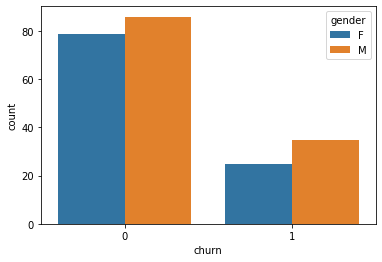

In [40]:
# 比较流失用户性别
gender_churn = df_withchurn.dropDuplicates(["userId", "gender"])\
        .groupby(['churn','gender']).count().toPandas()
sns.barplot(x='churn', y='count',hue='gender', data=gender_churn);

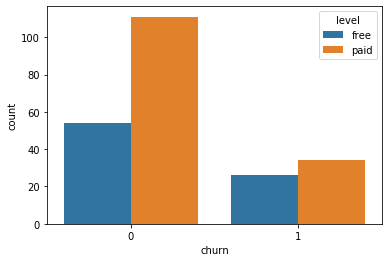

In [41]:
# 比较流失客户流失前的级别
level_churn = df_withchurn.orderBy(desc('time')).dropDuplicates(['userId'])\
            .groupby(['churn','level']).count().toPandas()
sns.barplot(x='churn',y='count', hue='level',data=level_churn);

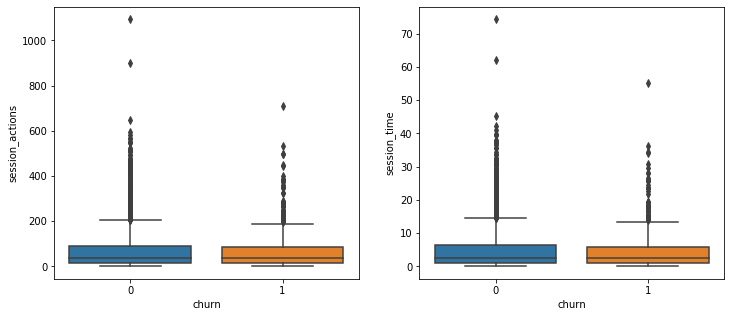

In [22]:
# 比较用户的每次会话的时长和动作次数
session_churn = df_withchurn.groupby("churn", "userId", "sessionId").agg(count('length').alias('session_actions'),
                                ((max(df_withchurn.ts) - min(df_withchurn.ts))/(1000*60*60)).alias('session_time')).toPandas()
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,5))
sns.boxplot(y='session_actions', x='churn', data=session_churn,ax = ax0);
sns.boxplot(y='session_time', x='churn',  data=session_churn, ax = ax1);

In [23]:
# 获取小时和天
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour) 
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_withchurn = df_withchurn.withColumn('hour',get_hour(df_withchurn.ts))
df_withchurn = df_withchurn.withColumn('day',get_day(df_withchurn.ts))

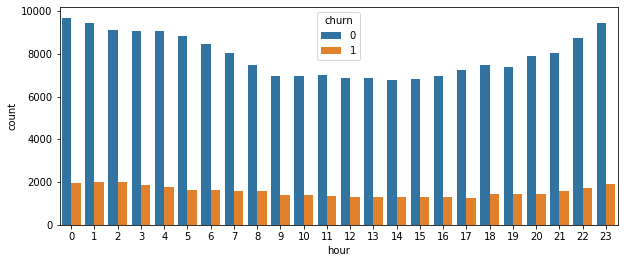

In [24]:
# 用户使用小时分布
hour_churn = df_withchurn.filter(df_withchurn.page=='NextSong').groupby('churn','hour').count()\
            .orderBy(df_withchurn.hour.cast('float')).toPandas()
hour_churn['hour'] = pd.to_numeric(hour_churn['hour'])
f,ax = plt.subplots(figsize=(10,4))
ax = sns.barplot(x='hour',y='count',hue='churn',data=hour_churn);

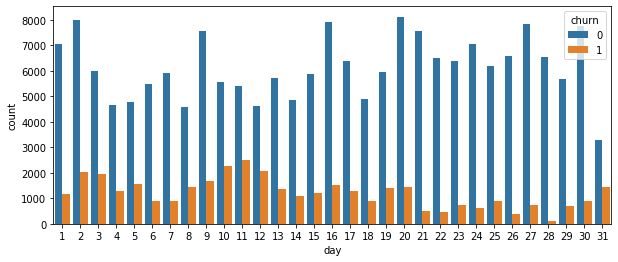

In [25]:
# 按天分布
day_churn = df_withchurn.filter(df_withchurn.page=='NextSong').groupby('churn','day').count()\
            .orderBy(df_withchurn.day.cast('float')).toPandas()
day_churn['day'] = pd.to_numeric(day_churn['day'])
f,ax = plt.subplots(figsize=(10,4))
ax = sns.barplot(x='day',y='count',hue='churn',data=day_churn);

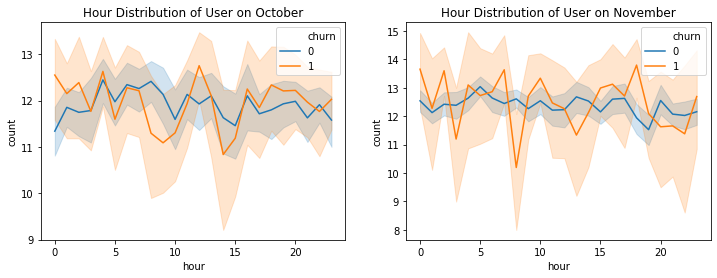

In [26]:
# 对比人均使用的小时分布
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).month)
df_withchurn = df_withchurn.withColumn('month',get_month(df_withchurn.ts))
user_count = df_withchurn.filter(df_withchurn.page=='NextSong').groupby('churn','month','day','hour','userId')\
        .count().orderBy(df_withchurn.month.cast('float'),df_withchurn.day.cast('float'),
                        df_withchurn.hour.cast('float')).toPandas()
user_count['hour'] = pd.to_numeric(user_count['hour'])
user_mean = user_count.groupby(['churn','month','day','hour'],as_index= False)['count'].mean()
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.set_title('Hour Distribution of User on October')
ax2.set_title('Hour Distribution of User on November')
sns.lineplot(x='hour',y='count',hue='churn',data=user_mean[user_mean['month']=='10'],ax=ax1);
sns.lineplot(x='hour',y='count',hue='churn',data=user_mean[user_mean['month']=='11'],ax=ax2);

##### 可以看出，流失用户的使用不稳定

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

### 特征抽取

##### 特征1：性别

In [27]:
f1_gender = df_withchurn.select('userId','gender').dropDuplicates()
f1_gender = f1_gender.replace(['F','M'],['0','1'],'gender')
f1_gender = f1_gender.select('userId',f1_gender.gender.cast('int'))

In [28]:
f1_gender.show(2)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
+------+------+
only showing top 2 rows



##### 特征2：是否付费

In [29]:
# 按照最后一次登陆时的状态来计算
f2_level = df_withchurn.select('userId','level').orderBy(desc('time')).dropDuplicates(['userId'])
f2_level = f2_level.replace(['free','paid'],['0','1'],'level')
f2_level = f2_level.select('userId',f2_level.level.cast('int'))

In [30]:
f2_level.show(2)

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
+------+-----+
only showing top 2 rows



##### 特征3：注册时间

In [31]:
# 按照注册时刻到最后一次登陆时刻计算时间
reg_time = df_withchurn.select('userId','registration').dropDuplicates()
last_time = df_withchurn.groupby('userId').agg(max('ts').alias('last_ts'))
f3_daysFromReg = reg_time.join(last_time, reg_time.userId == last_time.userId).select(reg_time.userId,
                 ((last_time.last_ts-reg_time.registration)/(1000*60*60*24)).alias('reg_days'))
f3_daysFromReg.show(2)

+------+-----------------+
|userId|         reg_days|
+------+-----------------+
|100010|55.64365740740741|
|200002|70.07462962962963|
+------+-----------------+
only showing top 2 rows



##### 特征4：每日在线时长

In [32]:
# 先按会话时长汇总
session_length = df_withchurn.groupby('userId','month','day','sessionId').agg((max('ts')-min('ts'))\
                                                                            .alias('session_time'))
# 再按天汇总
day_length = session_length.groupby('userId','month','day').agg(Fsum('session_time').alias('day_time'))
# 求平均值,按小时计
f4_avgLength = day_length.groupby('userId').agg((avg('day_time')/(1000*60*60)).alias('avg_length'))
f4_avgLength.show(2)

+------+-----------------+
|userId|       avg_length|
+------+-----------------+
|200002|3.794920634920635|
|100010|1.985895061728395|
+------+-----------------+
only showing top 2 rows



##### 特征5：添加好友数

In [93]:
f5_addFriend = df_withchurn.filter(df_withchurn.page=='Add Friend').groupby('userId').count()
f5_addFriend = f5_addFriend.withColumnRenamed('count','add_friends')
f5_addFriend.show(10)

+------+-----------+
|userId|add_friends|
+------+-----------+
|100010|          4|
|200002|          4|
|    51|         28|
|   124|         74|
|     7|          1|
|    54|         33|
|    15|         31|
|   155|         11|
|   132|         41|
|   154|          3|
+------+-----------+
only showing top 10 rows



##### 特征6：添加歌单数

In [97]:
f6_addPlaylist = df_withchurn.filter(df_withchurn.page=='Add to Playlist').groupby('userId').count()
f6_addPlaylist = f6_addPlaylist.withColumnRenamed('count','add_playlist')
f6_addPlaylist.show(10)

+------+------------+
|userId|add_playlist|
+------+------------+
|100010|           7|
|200002|           8|
|    51|          52|
|   124|         118|
|     7|           5|
|    15|          59|
|    54|          72|
|   155|          24|
|   132|          38|
|   154|           1|
+------+------------+
only showing top 10 rows



##### 特征7：是否降级

In [35]:
f7_downgrade = df_withchurn.filter(df_withchurn.page=='Submit Downgrade').groupby('userId').count()
f7_downgrade = f7_downgrade.withColumnRenamed('count','downgrade')
f7_downgrade.show(2)

+------+---------+
|userId|downgrade|
+------+---------+
|    54|        1|
|    11|        1|
+------+---------+
only showing top 2 rows



##### 特征8：是否升级

In [36]:
f8_upgrade = df_withchurn.filter(df_withchurn.page=='Submit Upgrade').groupby('userId').count()
f8_upgrade = f8_upgrade.withColumnRenamed('count','upgrade')
f8_upgrade.show(2)

+------+-------+
|userId|upgrade|
+------+-------+
|200002|      1|
|    54|      1|
+------+-------+
only showing top 2 rows



##### 特征9：thambs up次数

In [37]:
f9_thumbsUp = df_withchurn.filter(df_withchurn.page=='Thumbs Up').groupby('userId').count()
f9_thumbsUp = f9_thumbsUp.withColumnRenamed('count','thumbs_up')
f9_thumbsUp.show(2)

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
+------+---------+
only showing top 2 rows



##### 特征10：thambs down次数

In [38]:
f10_thumbsDown = df_withchurn.filter(df_withchurn.page=='Thumbs Down').groupby('userId').count()
f10_thumbsDown = f10_thumbsDown.withColumnRenamed('count','thumbs_down')
f10_thumbsDown.show(2)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
+------+-----------+
only showing top 2 rows



##### 特征11: 收听歌曲数

In [42]:
f11_songNum = df_withchurn.select(['userId','song']).groupby('userId').count().withColumnRenamed('count','song_num')
f11_songNum.show(2)

+------+--------+
|userId|song_num|
+------+--------+
|100010|     381|
|200002|     474|
+------+--------+
only showing top 2 rows



##### 特征12：收听歌手数

In [43]:
f12_artistNum = df_withchurn.filter(df_withchurn.page=='NextSong').select(['userId','artist']).dropDuplicates()\
                .groupby('userId').count().withColumnRenamed('count','artist_num')
f12_artistNum.show(2)

+------+----------+
|userId|artist_num|
+------+----------+
|100010|       252|
|200002|       339|
+------+----------+
only showing top 2 rows



##### 特征13：每次会话的平均歌曲数

In [45]:
f13_songsPerSession = df_withchurn.filter(df_withchurn.page =="NextSong").groupBy(["userId", "sessionId"]) \
                      .count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs')
f13_songsPerSession.show(2)

+------+------------------+
|userId|         avg_songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
+------+------------------+
only showing top 2 rows



##### 特征14：用户平均会话数

In [75]:
f14_sessionsPerUser = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId") \
                        .count().withColumnRenamed('count', 'sessions')
f14_sessionsPerUser.show(2)

+------+--------+
|userId|sessions|
+------+--------+
|100010|       7|
|200002|       6|
+------+--------+
only showing top 2 rows



##### 特征15：平均会话时长

In [99]:
f15_sesstime = df_withchurn.groupBy(["userId", "sessionId"]) \
                .agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60))
                .alias("sessTime"))
f15_avgtime = f15_sesstime.groupby("userId") \
                    .agg(avg(f15_sesstime.sessTime).alias("avgSessTime")) \
                    .orderBy("userId")
f15_avgtime.show(2)

+------+------------------+
|userId|       avgSessTime|
+------+------------------+
|    10|459.74722222222226|
|   100| 316.5190476190476|
+------+------------------+
only showing top 2 rows



##### 标签

In [47]:
label = df_withchurn.select('userId','churn').dropDuplicates()
label.show(2)

+------+-----+
|userId|churn|
+------+-----+
|100005|    1|
|200007|    0|
+------+-----+
only showing top 2 rows



### 特征汇总

In [115]:
# 将15个特征和标签汇总成一个dataframe
final = f1_gender.join(f2_level,'userId','left')
final = final.join(f3_daysFromReg,'userId','left')
final = final.join(f4_avgLength,'userId','left')
final = final.join(f5_addFriend,'userId','left')
final = final.join(f6_addPlaylist,'userId','left')
final = final.join(f7_downgrade,'userId','left')
final = final.join(f8_upgrade,'userId','left')
final = final.join(f9_thumbsUp,'userId','left')
final = final.join(f10_thumbsDown,'userId','left')
final = final.join(f11_songNum,'userId','left')
final = final.join(f12_artistNum,'userId','left')
final = final.join(f13_songsPerSession,'userId','left')
final = final.join(f14_sessionsPerUser,'userId','left')
final = final.join(f15_avgtime,'userId','left')
final = final.join(label,'userId','left')
final.show(2)

+------+------+-----+-----------------+-----------------+-----------+------------+---------+-------+---------+-----------+--------+----------+------------------+--------+------------------+-----+
|userId|gender|level|         reg_days|       avg_length|add_friends|add_playlist|downgrade|upgrade|thumbs_up|thumbs_down|song_num|artist_num|         avg_songs|sessions|       avgSessTime|churn|
+------+------+-----+-----------------+-----------------+-----------+------------+---------+-------+---------+-----------+--------+----------+------------------+--------+------------------+-----+
|100010|     0|    0|55.64365740740741|1.985895061728395|          4|           7|     null|   null|       17|          5|     381|       252|39.285714285714285|       7|154.48333333333332|    0|
|200002|     1|    1|70.07462962962963|3.794920634920635|          4|           8|     null|      1|       21|          6|     474|       339|              64.5|       6|266.40000000000003|    0|
+------+------+-----

In [116]:
final.count()

225

In [117]:
# 未统计到的值用0补充
final = final.fillna(0)
final.select([count(when(isnull(c) | isnan(c),c)).alias(c) for c in final.columns]).show()

+------+------+-----+--------+----------+-----------+------------+---------+-------+---------+-----------+--------+----------+---------+--------+-----------+-----+
|userId|gender|level|reg_days|avg_length|add_friends|add_playlist|downgrade|upgrade|thumbs_up|thumbs_down|song_num|artist_num|avg_songs|sessions|avgSessTime|churn|
+------+------+-----+--------+----------+-----------+------------+---------+-------+---------+-----------+--------+----------+---------+--------+-----------+-----+
|     0|     0|    0|       0|         0|          0|           0|        0|      0|        0|          0|       0|         0|        0|       0|          0|    0|
+------+------+-----+--------+----------+-----------+------------+---------+-------+---------+-----------+--------+----------+---------+--------+-----------+-----+



# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [118]:
final.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   60|
|    0|  165|
+-----+-----+



In [119]:
final.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- reg_days: double (nullable = false)
 |-- avg_length: double (nullable = false)
 |-- add_friends: long (nullable = true)
 |-- add_playlist: long (nullable = true)
 |-- downgrade: long (nullable = true)
 |-- upgrade: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- song_num: long (nullable = true)
 |-- artist_num: long (nullable = true)
 |-- avg_songs: double (nullable = false)
 |-- sessions: long (nullable = true)
 |-- avgSessTime: double (nullable = false)
 |-- churn: integer (nullable = true)



In [120]:
# 建立特征值向量
assembler = VectorAssembler(inputCols = final.columns[1:-1], outputCol="Features")
data = assembler.transform(final)
data.show(2)

+------+------+-----+-----------------+-----------------+-----------+------------+---------+-------+---------+-----------+--------+----------+------------------+--------+------------------+-----+--------------------+
|userId|gender|level|         reg_days|       avg_length|add_friends|add_playlist|downgrade|upgrade|thumbs_up|thumbs_down|song_num|artist_num|         avg_songs|sessions|       avgSessTime|churn|            Features|
+------+------+-----+-----------------+-----------------+-----------+------------+---------+-------+---------+-----------+--------+----------+------------------+--------+------------------+-----+--------------------+
|100010|     0|    0|55.64365740740741|1.985895061728395|          4|           7|        0|      0|       17|          5|     381|       252|39.285714285714285|       7|154.48333333333332|    0|[0.0,0.0,55.64365...|
|200002|     1|    1|70.07462962962963|3.794920634920635|          4|           8|        0|      1|       21|          6|     474| 

In [121]:
# 对特征向量标准化
scaler = StandardScaler(inputCol="Features", outputCol="ScaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)
data.show(2)

+------+------+-----+-----------------+-----------------+-----------+------------+---------+-------+---------+-----------+--------+----------+------------------+--------+------------------+-----+--------------------+--------------------+
|userId|gender|level|         reg_days|       avg_length|add_friends|add_playlist|downgrade|upgrade|thumbs_up|thumbs_down|song_num|artist_num|         avg_songs|sessions|       avgSessTime|churn|            Features|      ScaledFeatures|
+------+------+-----+-----------------+-----------------+-----------+------------+---------+-------+---------+-----------+--------+----------+------------------+--------+------------------+-----+--------------------+--------------------+
|100010|     0|    0|55.64365740740741|1.985895061728395|          4|           7|        0|      0|       17|          5|     381|       252|39.285714285714285|       7|154.48333333333332|    0|[0.0,0.0,55.64365...|[-1.0762390990345...|
|200002|     1|    1|70.07462962962963|3.7949206

In [122]:
df_model = data.select(data.ScaledFeatures.alias('features'),data.churn.alias('label'))
df_model.show(2)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-1.0762390990345...|    0|
|[0.92503195288915...|    0|
+--------------------+-----+
only showing top 2 rows



In [123]:
# 数据切分
train, validation = df_model.randomSplit([0.8, 0.2], seed=15)

### 模型训练

In [127]:
# 逻辑回归
model_lr = LogisticRegression()
model_lr = model_lr.fit(train)

# 预测
predict_train_lr = model_lr.transform(train)
predict_test_lr = model_lr.transform(validation)

# 计算roc_auc值

evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='label')

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_lr)))

print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_lr)))

The area under ROC for train set is 0.8262014483212629
The area under ROC for test set is 0.8359201773835923


In [128]:
# 随机森林
model_rf = RandomForestClassifier()
model_rf = model_rf.fit(train)

# 预测
predict_train_rf = model_rf.transform(train)
predict_test_rf = model_rf.transform(validation)

# 计算roc_auc值

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_rf)))

print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_rf)))

The area under ROC for train set is 0.9656023699802498
The area under ROC for test set is 0.8603104212860312


In [129]:
# 提升树
model_gbt = GBTClassifier()
model_gbt = model_gbt.fit(train)

# 预测
predict_train_gbt = model_rf.transform(train)
predict_test_gbt = model_rf.transform(validation)

# 计算roc_auc值

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_rf)))

print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_rf)))

The area under ROC for train set is 0.9656023699802498
The area under ROC for test set is 0.8603104212860313


In [124]:
# 编辑函数计算precision，recall，f1_score
def get_evaluate_scores(results):

    TP = results.filter("label = 1 and prediction = 1").count()
    FP = results.filter("label = 0 and prediction = 1").count()
    FN = results.filter("label = 1 and prediction = 0").count()
    TN = results.filter("label = 0 and prediction = 0").count()
    confusion_matrix = np.array([[TP,FP],[FN,TN]])
    print('混淆矩阵：\n', confusion_matrix)
    precision = TP / (TP + FP) 
    recall = TP / (TP + FN)
    f1 = 2*precision*recall / (precision+recall)
    print('精准率：', precision)
    print('召回率：', recall)
    print('F1得分：', f1)

In [132]:
# 逻辑回归
get_evaluate_scores(predict_test_lr)

混淆矩阵：
 [[ 7  3]
 [ 4 38]]
精准率： 0.7
召回率： 0.6363636363636364
F1得分： 0.6666666666666666


In [130]:
# 随机森林
get_evaluate_scores(predict_test_rf)

混淆矩阵：
 [[ 5  1]
 [ 6 40]]
精准率： 0.8333333333333334
召回率： 0.45454545454545453
F1得分： 0.5882352941176471


In [131]:
# 提升树
get_evaluate_scores(predict_test_gbt)

混淆矩阵：
 [[ 5  1]
 [ 6 40]]
精准率： 0.8333333333333334
召回率： 0.45454545454545453
F1得分： 0.5882352941176471


优先考虑效率，以上三种算法采用默认值计算，从分类效果来看，F1分数较高的是逻辑回归模型，随机森林和提升树相当，还有较大调优空间。

### 模型优化

In [157]:
# 逻辑回归模型
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
Model_lr = crossval.fit(train)


# gbt提升树模型
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[10, 20,30]) \
    .addGrid(gbt.maxBins, [20, 40, 60])\
    .addGrid(gbt.maxDepth,[2, 4, 6, 8,10]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

Model_gbt = crossval_gbt.fit(train)



# 随机森林模型
rf = RandomForestClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2,4,6,8]) \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

Model_rf = crossval_rf.fit(train)



lr_results = Model_lr.transform(validation)
gbt_results = Model_gbt.transform(validation)
rf_results = Model_rf.transform(validation)


# 逻辑回归
print('逻辑回归模型：{}'.format(get_evaluate_scores(lr_results)))

# 提升树
print('提升树模型：{}'.format(get_evaluate_scores(gbt_results)))

# 随机森林
print('随机森林模型：{}'.format(get_evaluate_scores(rf_results)))

混淆矩阵：
 [[ 4  1]
 [ 7 40]]
精准率： 0.8
召回率： 0.36363636363636365
F1得分： 0.5000000000000001
逻辑回归模型：None
混淆矩阵：
 [[ 9  6]
 [ 2 35]]
精准率： 0.6
召回率： 0.8181818181818182
F1得分： 0.6923076923076923
提升树模型：None
混淆矩阵：
 [[ 6  1]
 [ 5 40]]
精准率： 0.8571428571428571
召回率： 0.5454545454545454
F1得分： 0.6666666666666665
随机森林模型：None


In [158]:
# 逻辑回归预测
predict_train_lr_ = Model_lr.transform(train)
predict_test_lr_ = Model_lr.transform(validation)

# 计算roc_auc值

print("The area under ROC for train set is: {}".format(evaluator.evaluate(predict_train_lr_)))

print("The area under ROC for test set is: {}".format(evaluator.evaluate(predict_test_lr_)))

The area under ROC for train set is: 0.7819289005924942
The area under ROC for test set is: 0.8758314855875834


In [159]:
## 提升树预测
predict_train_gbt_ = Model_gbt.transform(train)
predict_test_gbt_ = Model_gbt.transform(validation)

# 计算roc_auc值

print("The area under ROC for train set is: {}".format(evaluator.evaluate(predict_train_gbt_)))

print("The area under ROC for test set is: {}".format(evaluator.evaluate(predict_test_gbt_)))

The area under ROC for train set is: 0.9671658986175115
The area under ROC for test set is: 0.8325942350332596


In [162]:
# 随机森林预测
predict_train_rf_ = Model_rf.transform(train)
predict_test_rf_ = Model_rf.transform(validation)

# 计算roc_auc值

print("The area under ROC for train set is: {}".format(evaluator.evaluate(predict_train_rf_)))

print("The area under ROC for test set is: {}".format(evaluator.evaluate(predict_test_rf_)))

The area under ROC for train set is: 0.9349078341013822
The area under ROC for test set is: 0.8636363636363639


In [144]:
#逻辑回归
best_parameters = [(
                [{key.name: paramValue} for key, paramValue in zip(params.keys(),params.values())], metric) \
            for params, metric in zip(
                Model_lr.getEstimatorParamMaps(),
                Model_lr.avgMetrics)]
lr_best_params=sorted(best_parameters,key=lambda el:el[1],reverse=True)[0]
print(lr_best_params)

([{'elasticNetParam': 1.0}, {'regParam': 0.05}], 0.7776933253921723)


In [145]:
#提升树
best_parameters = [(
                [{key.name: paramValue} for key, paramValue in zip(params.keys(),params.values())], metric) \
            for params, metric in zip(
                Model_gbt.getEstimatorParamMaps(),
                Model_gbt.avgMetrics)]
gbt_best_params=sorted(best_parameters,key=lambda el:el[1],reverse=True)[0]
print(gbt_best_params)

([{'maxIter': 30}, {'maxBins': 40}, {'maxDepth': 2}], 0.7495034157073681)


In [147]:
#随机森林
best_parameters = [(
                [{key.name: paramValue} for key, paramValue in zip(params.keys(),params.values())], metric) \
            for params, metric in zip(
                Model_rf.getEstimatorParamMaps(),
                Model_rf.avgMetrics)]
rf_best_params=sorted(best_parameters,key=lambda el:el[1],reverse=True)[0]
print(rf_best_params)

([{'impurity': 'gini'}, {'maxDepth': 4}], 0.7611382537511129)


# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。